In [220]:
import pandas as pd
import os
import string
import re

!pip install keras

from keras.utils import np_utils
import numpy as np

# !git clone https://github.com/davordavidovic/NLP-lyrics-generator.git


In [0]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.random.seed(7)

df1 = pd.read_csv('./NLP-lyrics-generator/data/lyrics_part1.csv')
df2 = pd.read_csv('./NLP-lyrics-generator/data/lyrics_part2.csv')
df3 = pd.read_csv('./NLP-lyrics-generator/data/lyrics_part3.csv')
df4 = pd.read_csv('./NLP-lyrics-generator/data/lyrics_part4.csv')
df_part_1 = pd.concat([df1, df2])
df_part_2 = pd.concat([df3, df4])
df = pd.concat([df_part_1, df_part_2])
df = df.dropna() #there were around 10000 rows with no lyrics so drop them


df['genre'] = df['genre'].replace({'Hip-Hop': 'Rap'})

In [222]:
df.groupby('genre').count()

,Unnamed: 0,index,song,year,artist,lyrics
genre,,,,,,
Country,14387,14387,14387,14387,14387,14387
Electronic,7966,7966,7966,7966,7966,7966
Folk,2243,2243,2243,2243,2243,2243
Indie,3149,3149,3149,3149,3149,3149
Jazz,7970,7970,7970,7970,7970,7970
Metal,23759,23759,23759,23759,23759,23759
Not Available,23941,23941,23941,23941,23941,23941
Other,5189,5189,5189,5189,5189,5189
Pop,40466,40466,40466,40466,40466,40466


In [0]:
words_to_remove = set(['horns', 'chorus', 'verse', 'bridge','instrumental'])
def prepare_text(text):
  text = text.lower()
  text = text.replace('\n', ' ')
  text = text.split()
  
  
  for index, word in enumerate(text):
    word = word.strip(string.punctuation)
    #remove words still containing non alphabetic chars 
    word = re.sub("[^\x00-\x7F]+",' ', word)
    word = re.sub("[\W]", ' ', word)
    word = re.sub("\d+", ' ', word)

    text[index] = word
  
  text = [x for x in text if x not in words_to_remove]
  
  text = " ".join(text)
  return text
   

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
from keras.utils import np_utils


def index2sen(seq,vocab):
    tokens = [vocab[int(t)] for t in seq]
    sen = " ".join(tokens)
    return sen

def build_vocab(songs, min_frq):

  vectorizer = CountVectorizer(stop_words=[],min_df=min_frq)
  X = vectorizer.fit_transform(songs)


  vocab_dict = vectorizer.vocabulary_
  vocab_list =  list(vocab_dict)

  return vocab_dict




def load_songs_and_genres(genres, num_songs):
  
  df_songs = df[df['genre'].isin(genres)]
  
  try:
    df_sampled = df_songs[df_songs['genre']==genres[0]].sample(n=num_songs)
  except:
    df_sampled = df_songs[df_songs['genre']==genres[0]]
    
  for genre in genres[1:]:
    try:
      df_sampled = pd.concat([df_songs[df_songs['genre']==genre].sample(n=num_songs), df_sampled])
    except:
      df_sampled = pd.concat([df_songs[df_songs['genre']==genre], df_sampled])

  df_sampled = df_sampled.sample(frac=1).reset_index(drop=True)
  
  songs = df_sampled['lyrics'].map(prepare_text)
  genres = df_sampled['genre']
  return songs.values, genres.values



def songs_to_supervised(songs, genres):
  data_x = []
  data_y = []

  for i, song in enumerate(songs):
      words = song.split()
      sequence = []
      for word in words:

        if word in words_int:
          sequence.append(words_int[word])
          

      if len(sequence) > 5:
        data_x.append(sequence)
        data_y.append(genre_int[genres[i].lower()])

              
          
  return np.array(data_x), np.array(data_y)
  


In [0]:
genres_list = ['Rap','Pop', 'Country', 'Rock', 'Jazz']

In [0]:


songs, genres = load_songs_and_genres(genres_list, 24000)

vocab_dict = build_vocab(songs, min_frq=2)
genre_dict = build_vocab(genres, min_frq=1)

vocab_len = len(vocab_dict)
genre_len = len(genre_dict)

set_words = set(list(vocab_dict.keys()))
set_genres = set(list(genre_dict.keys()))

int_words = dict((i, w) for i, w in enumerate(set_words))
words_int = dict((i, w) for w, i in enumerate(set_words))

int_genre = dict((i, w) for i, w in enumerate(set_genres))
genre_int = dict((i, w) for w, i in enumerate(set_genres))


In [227]:
X, y = songs_to_supervised(songs, genres)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

unique_train = [int_genre[value] for value in unique_train]
unique_test = [int_genre[value] for value in unique_test]


print('Train size:', dict(zip(unique_train, counts_train)))
print('Test size:', dict(zip(unique_test, counts_test)))



Train size: {'rock': 18848, 'pop': 19026, 'country': 11400, 'rap': 19168, 'jazz': 6199}
Test size: {'rock': 4622, 'pop': 4782, 'country': 2913, 'rap': 4724, 'jazz': 1620}


In [0]:
#--------naive bayes------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
x_nb, y_nb = load_songs_and_genres(genres_list, 24000)
xnb_train, xnb_test, ynb_train, ynb_test = train_test_split(x_nb, y_nb, test_size=0.2, random_state=7)

In [229]:
model.fit(xnb_train, ynb_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

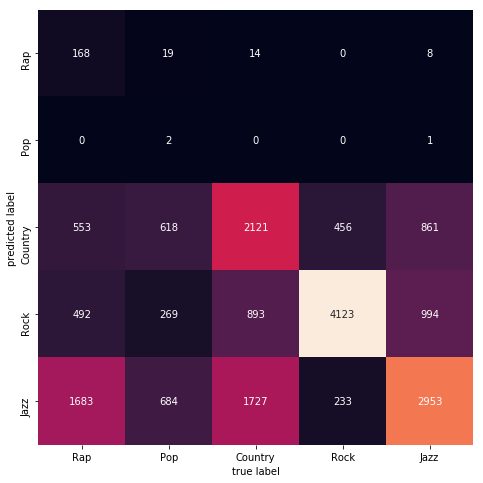

In [236]:
labels = model.predict(xnb_test)
plt.figure(figsize=(12, 8))
mat = confusion_matrix(ynb_test, labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=genres_list, yticklabels=genres_list)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig('./confmat_naivebayes.pdf', bbox_inches='tight', format='pdf')

In [234]:
print("Number of mislabeled points out of a total %d points : %d" % (len(xnb_test),(ynb_test != labels).sum()))

Number of mislabeled points out of a total 18872 points : 9505


In [239]:
from sklearn.metrics import accuracy_score

accuracy_score(ynb_test, labels)

0.49634378974141585

In [0]:
# truncate and pad input sequences
max_song_len = 500
x_train = sequence.pad_sequences(x_train, maxlen=max_song_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_song_len)



In [0]:
from keras.utils import to_categorical

def encode(data):
  return to_categorical(data)

def decode(data):
  return np.argmax(data)

In [0]:
use_embedded = True


if not use_embedded:
  x_train = np.reshape(x_train, (len(x_train), max_song_len, 1))
  x_test = np.reshape(x_test, (len(x_test), max_song_len, 1))
  shape_input = x_train[0].shape



In [209]:
from keras.layers import Embedding, LSTM, Dense,Dropout, CuDNNLSTM, Conv1D, MaxPooling1D
from keras import metrics

embedding_len = 32
num_classes = len(genres_list)

def create_model(layers, units, binary=True):
  #lstm sequence to categoriemodel
  model = Sequential()
  
#   model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#   model.add(MaxPooling1D(pool_size=2))
  
  if use_embedded:
    model.add(Embedding(vocab_len, embedding_len, input_length=max_song_len))
  else:
    model.add(CuDNNLSTM(units,return_sequences=True,input_shape=shape_input))
    model.add(Dropout(0.5))
  
  for l in range(layers-1):
    model.add(CuDNNLSTM(units,return_sequences=True))
    model.add(Dropout(0.5))
    
  model.add(CuDNNLSTM(units))
  model.add(Dropout(0.5)) 
  
  if binary:
    activ_func = 'sigmoid'
    loss_func = 'binary_crossentropy'
    output = 1
    acc = ['accuracy']
  else:
    activ_func = 'softmax'
    output = num_classes
    loss_func = 'categorical_crossentropy'
    acc = ['categorical_accuracy']

  model.add(Dense(output, activation=activ_func))
  model.compile(loss=loss_func, optimizer='rmsprop',metrics=acc)
  
  return model


model = create_model(2, 100, binary=False)
history = model.fit(x_train, encode(y_train), validation_data=(x_test, encode(y_test)), epochs=50, batch_size=1024)

Train on 74629 samples, validate on 18658 samples
Epoch 1/50
74629/74629 [==============================] - 36s 488us/step - loss: 1.4454 - categorical_accuracy: 0.3664 - val_loss: 1.2475 - val_categorical_accuracy: 0.4511
Epoch 2/50
74629/74629 [==============================] - 30s 396us/step - loss: 1.2534 - categorical_accuracy: 0.4535 - val_loss: 1.1620 - val_categorical_accuracy: 0.5095
Epoch 3/50
74629/74629 [==============================] - 29s 389us/step - loss: 1.1582 - categorical_accuracy: 0.5096 - val_loss: 1.1215 - val_categorical_accuracy: 0.5330
Epoch 4/50
74629/74629 [==============================] - 29s 388us/step - loss: 1.1277 - categorical_accuracy: 0.5467 - val_loss: 1.0929 - val_categorical_accuracy: 0.5593
Epoch 5/50
74629/74629 [==============================] - 29s 392us/step - loss: 1.0443 - categorical_accuracy: 0.5912 - val_loss: 1.1006 - val_categorical_accuracy: 0.5622
Epoch 6/50
74629/74629 [==============================] - 29s 390us/step - loss: 0.99

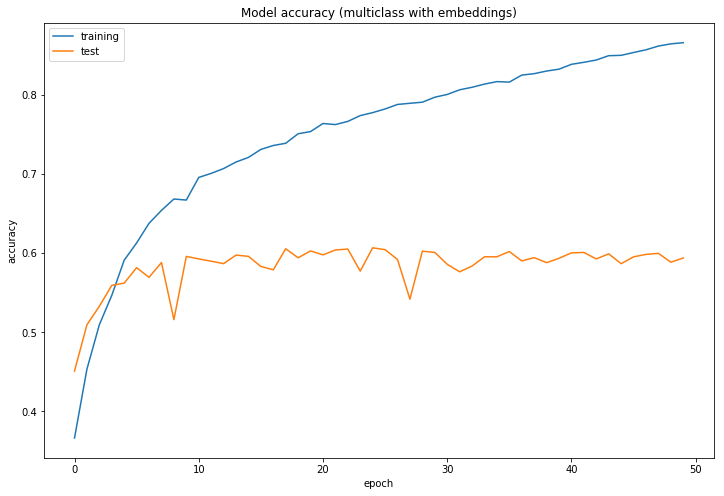

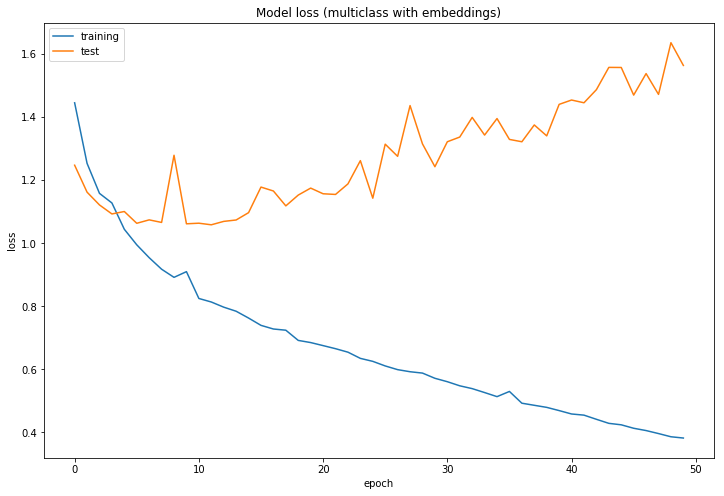

In [211]:
import matplotlib.pyplot as plt
num_epochs = 100

plt.figure(figsize=(12, 8))
#TODO save plot on training curve
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy (multiclass with embeddings)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'test'], loc='upper left')

plt.savefig('./plot_multiclass_withembeddings_acc.pdf', bbox_inches='tight', format='pdf')

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (multiclass with embeddings)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'test'], loc='upper left')
plt.savefig('./plot_multiclass_withembeddings_loss.pdf', bbox_inches='tight', format='pdf')


In [0]:
# y_scores = model.predict(x_test)
for i in y_scores:
  print(decode(i))

In [0]:
import seaborn as sns
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, roc_curve, roc_auc_score

y_scores = model.predict(x_test)

y_true = [decode(c) for c in y_test]
y_scores = [decode(c) for c in y_scores]

#----from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823-----
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt="d", cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./confmat_multiclass_withembeddings.pdf', bbox_inches='tight', format='pdf')
    return fig
  
def plot_roc_curve(tpr, fpr, auc):
  x = np.linspace(0,1,10)
  fig = plt.figure(figsize=(10,7))
  plt.plot(x,x,':b')
  plt.xlabel('False positive rate')
  plt.xlabel('True positive rate')
  plt.plot(fpr,tpr,label="ROC curve, auc="+str(auc))
  plt.plot()
  plt.legend(loc=4)
  plt.savefig('./roc_multiclass_withembeddings.pdf', bbox_inches='tight', format='pdf')
  return fig


def print_stats(y_true, y_scores):
#   y_pred = y_scores.round().astype('int32').flatten()
  accuracy = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1_score = 2 * (precision * recall) / (precision + recall)
  confusion_mat = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = confusion_mat.ravel()
  auc = roc_auc_score(y_true, y_scores).astype('float32')
  fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)

  print('True positives (1 - rap):', tp)
  print('True negatives (0 - pop):', tn)
  print('False positives:', fp)
  print('False negatives:', fn)
  print('Accuracy:', accuracy)
  print('Recall (true positive rate):', recall)
  print('Precision:', precision)
  print('F1_score:', f1_score)
  print('AUC Score:', auc)
  print('---------------------')
  print('Confusion matrix:')
  plot_confusion_matrix(confusion_mat, ['Pop', 'Rap'])
  plot_roc_curve(tpr,fpr,auc)

In [218]:
print_stats(y_true, y_scores)

AttributeError: ignored